In [112]:
import numpy as np
import random
import cvxpy as cp
import matplotlib.pyplot as plt

The following is a summary of a research paper:
 
Beveridge, Andrew, and Stan Wagon. “The Sorting Hat Goes to college.” Mathematics Magazine, vol. 87, no. 4, Oct. 2014, pp. 243–251, https://doi.org/10.4169/math.mag.87.4.243. 

## Problem 

Assign first-years students to their desired courses (about 500 students must be placed into about 35 first-year courses). Maximize overall student satisfaction such that each student is assigned into a course that they ranked. 

## Solution

### Hungarian Algorithm (minimum weight perfect matching algorithm)

Weighted bipartite graph - n vertices in one part correspond to n vertices in the other part

- create a bipartite graph that enforced the constraints on class size and demographics
- choose a weighting scheme that ensured trade-offs were consistent with the goals an priorities of the AP office

The Hungarian algorithm works well but sometimes the constraints cannot be met, which is why the Integer Linear Programming method works better as it handles a wide variety of constraints.


### Integer Programming problem

**Parameters:**
- students $S_i, 1 \leq i \leq n$
- courses $C_j, 1 \leq j \leq m$
- M, F, I are indices corresponding to male, female, and international students
- preferences $P_i$
- $X_j$ : set of students i having $C_j$ as one of their choices, where $j \in P_i$
 
\* worst case $X_j = \emptyset$

**Decision Variables**
- $x_{i,j}$ = 1 if for each pair $(S_i, C_j)$ where $j \in P_i$, $S_i$ is assigned to $C_j$, and 0 otherwise
- $\sum_{j \in P_i} x_{i,j}$ = 1 for each $i \leq n$ and $x_{i,j} \in \{0,1\}$

**Objective Function**
$$\text{min } \sum_{i=1}^n x_{i,j_{i,1}} + \alpha x_{i,j_{i,2}} + \alpha^2 x_{i,j_{i,3}}  + \alpha^3 x_{i,j_{i,4}}$$ 
where $j_{i,1}, ..., j_{i,4}$ are student $S_i$'s four choices and $\alpha > 1$ 

* $\alpha$ is a value chosen according to the trade-offs for swapping students between classes
The weight of placing a student in a course increases as it is further from the first choice.

**Constraints**
1. Each class size should be from 10 to 16 students
2. The demographics of each class should be roughly comparable to the entire student body (60% female and 11% international student)
* sometimes the problem gives infeasible solutions, so the students are placed into an unranked course

**Course size constraint**

The sum of the number of students enrolled in each course $C_j$ ranges from L to U:
- $L \leq \sum_{i \in X_j} x_{i,j} \leq U$ for each $j \leq m$

Typically, we have $(L, U) = (12, 16)$ so the course can have 12 to 16 students. However, it is common to have a course that allows more than 16 or less than 12. We introduce $q_{j,s}$ where s is the size of $C_j$ and $9 \leq s \leq 17$. Suppose we have $Q_{17}, Q_{11}, Q_{10}, Q_9$ that represents the maximum number of students allowed in each class 17, 11, 10, and 9 respectively. Then, the ideal size of each $C_j$ for $Q_{17}, Q_{11}, Q_{10}, Q_9$ are:
* $\sum_j q_{j,17} \leq Q_{17}$ 
* $\sum_j q_{j,11} \leq Q_{11}$ 
* $\sum_j q_{j,10} \leq Q_{10}$ 
* $\sum_j q_{j,9} \leq Q_{9}$ 

However, we need to make sure that each course only takes a unique maximum number of students ranging from 9 to 17:
$$\sum_{s=9}^{17} q_{j,s} = 1$$

Therefore, we have the total number of students enrolled in $C_j$ be equal to the maximum number of students a course can have by multiplying s with $\sum_{s=9}^{17} q_{j,s}$
$$\sum_{i \in X_j} x_{i,j} = \sum_{s=9}^{17} sq_{j,s}$$ 


**Gender constraint**

There are at least 4 male and 4 female in each course

* $\sum_{i \in M \cap X_j} x_{i,j} \geq 4$
* $\sum_{i \in F \cap X_j} x_{i,j} \geq 4$

The same idea from the course size constraint can be used for the gender constraint to help loosened the constraint of having at least 4 male and female.

The paper introduced a new variable $y_{m,j} = 1$ when $C_j$ has a value of m males, and 0 otherwise. So, we can make sure that $C_j$ has a maximum of m number of males:
$$\sum_{m=0}^{17} y_{m,j} = 1$$
and thus, the total number of male students enrolled in $C_j$ can be equal to the maximum number of male students a course can have by multiplying m with $\sum_{m=0}^{17} y_{m,j}$:
$$\sum_{i \in M \cap X_j} x_{i,j} = \sum_{m=0}^{17} my_{m,j}$$

Similarly, we will have the same formula for the number of females in a course:
$$\sum_{i \in F \cap X_j} x_{i,j} = \sum_{f=0}^{17} fy_{f,j}$$

**International constraint**

Each course contains at most B international students

$\sum_{i \in I \cap X_j} x_{i,j} \leq B$





## Building Solution

### Defining the dataset

we have to create a dummy set for 544 students and 35 courses. The students will need to be classfied into male, female and international students. We need a separate array to define preferences of the students by creating an ordered list of courses. Each courses also need the limitation for the number of students. 

In [9]:
n = 544 # number of students
m = 35 # number of courses

**Create courses dataset**

The course dataset will have 35 courses each with an id from 1 to 35 and a course limit ranging from 9 to 17. 

In [90]:
# create a dictionary to store course number and 
courses = {}

for i in range(1,m+1): # iterate to fill m number of courses
    course_id = i
    # set random limit from 9 to 17 with more max_student = 16
    prob = [0.02, 0.02, 0.02, 0.03, 0.03, 0.05, 0.13, 0.42, 0.28]
    max_students = np.random.choice(range(9,18), p = prob) 
    # let i be the course id from 1 to 35
    courses[i] = {'max': max_students}

print(len(courses))

for i in list(courses.items())[:5]:
    print(i)

35
(1, {'max': 17})
(2, {'max': 17})
(3, {'max': 17})
(4, {'max': 17})
(5, {'max': 16})


<class 'numpy.ndarray'>


The total number of seats should be more or equal to the total number of students.

In [91]:
# check how many empty seats
total_seats = 0
for course in courses.values():
    total_seats += course['max']

print(total_seats)

550


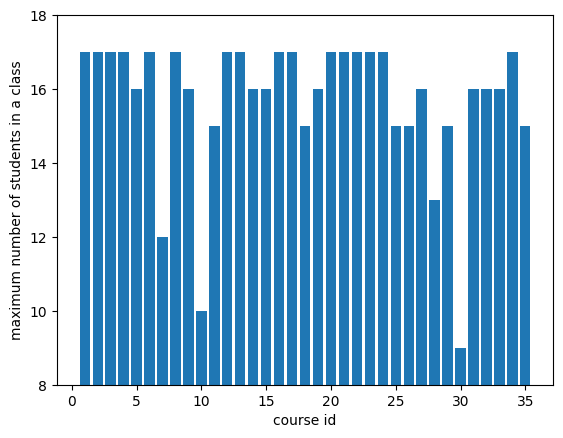

In [92]:
# bar graph to show maximum number of seats per class
course_id = [i for i in range(1,m+1)]
max_list = [course['max'] for course in courses.values()]

plt.bar(course_id, max_list)
plt.ylim(8,18)
plt.xlabel('course id')
plt.ylabel('maximum number of students in a class')
plt.show()

**Create student dataset**

The student dataset should not be completely random because according to the paper, the Machester college has 60% female students and 11% international students.

- Let gender be 1 for female and 0 otherwise. 
- Let international be 1 for international students and 0 otherwise.
- Let preferences be an ordered list of courses

In [109]:
# create a dictionary to store data
course_id = list(courses.keys())
students = {}
for i in range(1,n+1): # iterate to fill n students
    rand_gender = random.random()
    rand_international = random.random()
    
    # probability of having female student is 60%
    gender = 1 if (rand_gender > 0.6) else 0
    # probability of international student is 11%
    international = 1 if(rand_international < 0.11) else 0

    # create list of preference
    preference = random.sample(course_id, 4)
    # let i be the student id from 1 to 544
    students[i] = {'gender': gender, 'international': international,
                   'preference': preference}

In [110]:
for i in list(students.items())[:5]:
    print(i)

(1, {'gender': 0, 'international': 0, 'preference': [3, 17, 35, 2]})
(2, {'gender': 0, 'international': 0, 'preference': [31, 22, 23, 12]})
(3, {'gender': 1, 'international': 0, 'preference': [27, 25, 6, 32]})
(4, {'gender': 0, 'international': 0, 'preference': [25, 7, 11, 10]})
(5, {'gender': 0, 'international': 0, 'preference': [22, 34, 28, 19]})


This would indicate that the student with id 1 is a male, non-international student and their first-ranked course is id 3 followed by course id 17, 35, then 2.

**Set the objective function**

$$\text{min } \sum_{i=1}^n x_{i,j_{i,1}} + \alpha x_{i,j_{i,2}} + \alpha^2 x_{i,j_{i,3}}  + \alpha^3 x_{i,j_{i,4}}$$ 
where $j_{i,1}, ..., j_{i,4}$ are student $S_i$'s four choices and $\alpha > 1$ 

In [136]:
# let alpha = 2
a = 2

# set decision variable
x = cp.Variable((n, m), integer = True)

# set objective function
objective = 0
for i in range(1, n+1):
    for j in range(4):
        # for each students with id i, get the course id in the preference
        k = students[i]['preference'][j]
        # x is using index base 0
        objective += cp.multiply((a**j), x[i-1, k-1])

objective = cp.Minimize(objective)

**Set course constraints**
$$\sum_{s=9}^{17} q_{j,s} = 1$$
$$\sum_{i \in X_j} x_{i,j} = \sum_{s=9}^{17} sq_{j,s}$$ 

In [148]:
course_constraint = []

# create variable q and let it have a size of m by the range of course size (18-9) 
size = 9
q = cp.Variable((m, size), integer = True)
# constraint for checking each course only have one maximum size
course_constraint += [cp.sum(q[j,:]) == 1 for j in range(m)]
# sum of student i for each class j should be equal to the maximum number of the class
course_constraint += [cp.sum(x[:, j]) == cp.sum([s * q[j, s] for s in range(9)]) for j in range(m)]

**Set gender constraints**

$$\sum_{m=0}^{17} y_{m,j} = 1$$
$$\sum_{f=0}^{17} y_{f,j} = 1$$
$$\sum_{i \in M \cap X_j} x_{i,j} = \sum_{m=0}^{17} my_{m,j}$$
$$\sum_{i \in F \cap X_j} x_{i,j} = \sum_{f=0}^{17} fy_{f,j}$$

In [ ]:
gender_costraint = []

**Set international students constraints**

$$\sum_{i \in I \cap X_j} x_{i,j} \leq 8$$

In [ ]:
international_constraint = []

**Solve**

In [ ]:
constraints = course_constraint + gender_constraint + international_constraint